# Import Dependencies

In [1]:
# Import the reqiured libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [2]:
import tensorflow as tf

print(tf.__version__)

2.8.0


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.metrics import mean_squared_error
from tensorflow.keras import backend as K

In [4]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load the Data

In [6]:
products = pd.read_csv('retail_price.csv', usecols=['product_id', 'product_category_name', 'product_score'])
transactions = pd.read_csv('retail_price.csv', usecols=['unit_price', 'qty', 'freight_price', 'product_weight_g', 'lag_price'])
competitors = pd.read_csv('retail_price.csv', usecols=['comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2'])

### 1. Products Info

In [7]:
products.head()

,product_id,product_category_name,product_score
0,bed1,bed_bath_table,4.0
1,bed1,bed_bath_table,4.0
2,bed1,bed_bath_table,4.0
3,bed1,bed_bath_table,4.0
4,bed1,bed_bath_table,4.0


In [8]:
products.describe()
products.describe(include=['O'])

,product_score
count,676.000000
mean,4.085503
std,0.232021
min,3.300000
25%,3.900000
50%,4.100000
75%,4.200000
max,4.500000


,product_id,product_category_name
count,676,676
unique,52,9
top,health5,garden_tools
freq,20,160


In [9]:
products[products.isnull().any(axis=1)]

,product_id,product_category_name,product_score


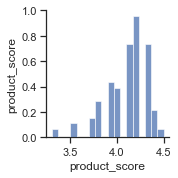

In [10]:
sns.pairplot(products)

### 2. Transactions Info

In [11]:
transactions.head()

,qty,freight_price,unit_price,product_weight_g,lag_price
0,1,15.100000,45.95,350,45.90
1,3,12.933333,45.95,350,45.95
2,6,14.840000,45.95,350,45.95
3,4,14.287500,45.95,350,45.95
4,2,15.100000,45.95,350,45.95


In [12]:
transactions.describe()

,qty,freight_price,unit_price,product_weight_g,lag_price
count,676.000000,676.000000,676.000000,676.000000,676.000000
mean,14.495562,20.682270,106.496800,1847.498521,107.399684
std,15.443421,10.081817,76.182972,2274.808483,76.974657
min,1.000000,0.000000,19.900000,100.000000,19.850000
25%,4.000000,14.761912,53.900000,348.000000,55.668750
50%,10.000000,17.518472,89.900000,950.000000,89.900000
75%,18.000000,22.713558,129.990000,1850.000000,129.990000
max,122.000000,79.760000,364.000000,9750.000000,364.000000


In [13]:
transactions[transactions.isnull().any(axis=1)]

,qty,freight_price,unit_price,product_weight_g,lag_price


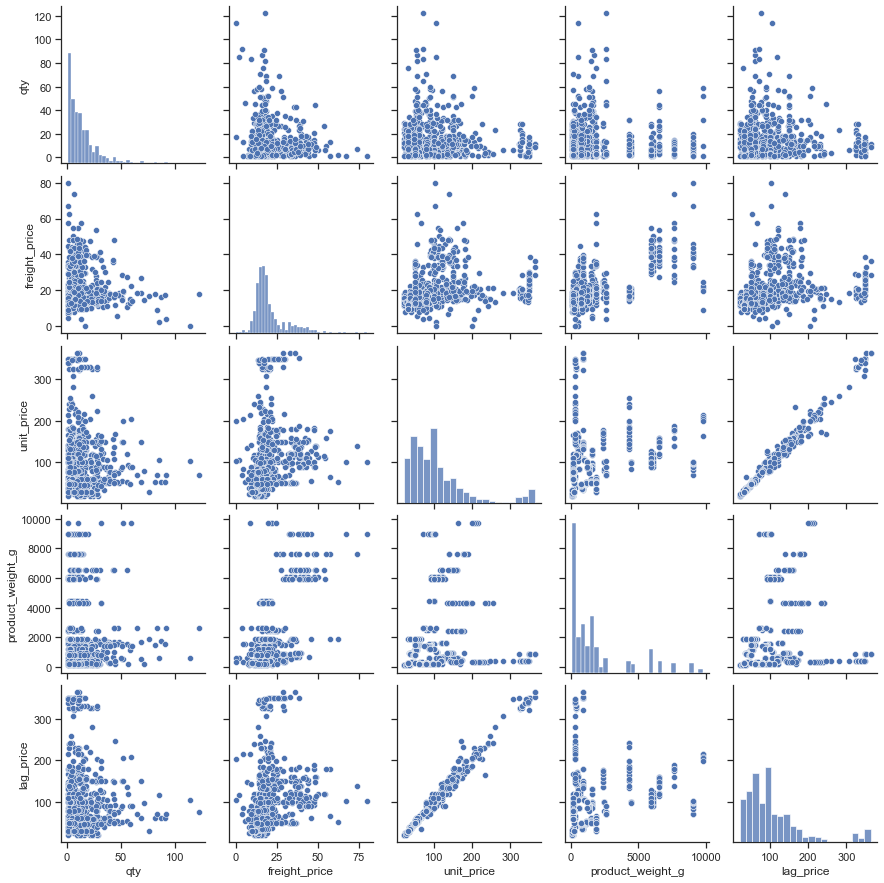

In [14]:
sns.pairplot(transactions)

(array([172., 155., 170.,  73.,  39.,  16.,   9.,   1.,  10.,  31.]),
 array([ 19.9 ,  54.31,  88.72, 123.13, 157.54, 191.95, 226.36, 260.77,
        295.18, 329.59, 364.  ]),
 <BarContainer object of 10 artists>)

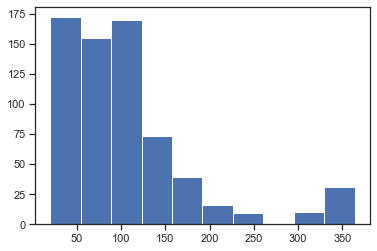

In [15]:
plt.hist(transactions.unit_price)

### 3. Dates Info

In [16]:
# dates.head()

In [17]:
# dates.describe()

In [18]:
# dates[dates.isnull().any(axis=1)]

In [19]:
# dates.dtypes

In [20]:
# sns.pairplot(dates)

### 4. Competitor Info

In [21]:
competitors.head()

,comp_1,ps1,fp1,comp_2,ps2,fp2
0,89.9,3.9,15.011897,215.000000,4.4,8.760000
1,89.9,3.9,14.769216,209.000000,4.4,21.322000
2,89.9,3.9,13.993833,205.000000,4.4,22.195932
3,89.9,3.9,14.656757,199.509804,4.4,19.412885
4,89.9,3.9,18.776522,163.398710,4.4,24.324687


In [22]:
competitors.describe()

,comp_1,ps1,fp1,comp_2,ps2,fp2
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,79.452054,4.159467,18.597610,92.930079,4.123521,18.620644
std,47.933358,0.121652,9.406537,49.481269,0.207189,6.424174
min,19.900000,3.700000,0.095439,19.900000,3.300000,4.410000
25%,49.910000,4.100000,13.826429,53.900000,4.100000,14.485000
50%,69.900000,4.200000,16.618984,89.990000,4.200000,16.811765
75%,104.256549,4.200000,19.732500,117.888889,4.200000,21.665238
max,349.900000,4.500000,57.230000,349.900000,4.400000,57.230000


In [23]:
competitors[competitors.isnull().any(axis=1)]

,comp_1,ps1,fp1,comp_2,ps2,fp2


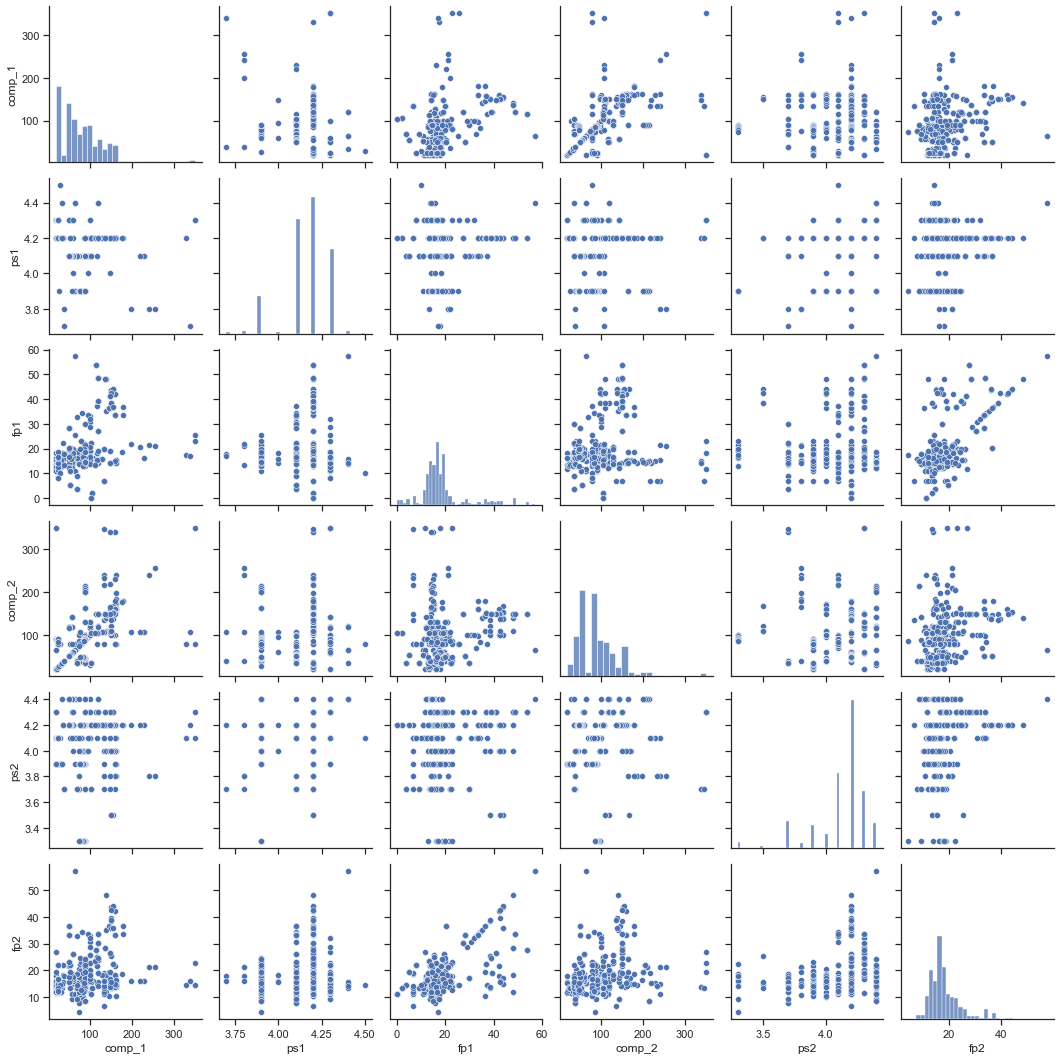

In [24]:
sns.pairplot(competitors)

### Merge Data

In [25]:
products_ls = products.join(transactions)
products_ls = products_ls.join(competitors)
products_ls.head(20)

,product_id,product_category_name,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
0,bed1,bed_bath_table,4.0,1,15.100000,45.950000,350,45.900000,89.900000,3.9,15.011897,215.000000,4.4,8.760000
1,bed1,bed_bath_table,4.0,3,12.933333,45.950000,350,45.950000,89.900000,3.9,14.769216,209.000000,4.4,21.322000
2,bed1,bed_bath_table,4.0,6,14.840000,45.950000,350,45.950000,89.900000,3.9,13.993833,205.000000,4.4,22.195932
3,bed1,bed_bath_table,4.0,4,14.287500,45.950000,350,45.950000,89.900000,3.9,14.656757,199.509804,4.4,19.412885
4,bed1,bed_bath_table,4.0,2,15.100000,45.950000,350,45.950000,89.900000,3.9,18.776522,163.398710,4.4,24.324687
5,bed1,bed_bath_table,4.0,3,15.100000,45.950000,350,45.950000,89.900000,3.9,21.572143,45.950000,4.0,15.100000
6,bed1,bed_bath_table,4.0,11,15.832727,40.531818,350,45.950000,89.900000,3.9,16.294000,40.531818,4.0,15.832727
7,bed1,bed_bath_table,4.0,6,15.230000,39.990000,350,40.531818,88.488235,3.9,18.898333,39.990000,4.0,15.230000
8,bed1,bed_bath_table,4.0,19,16.533684,39.990000,350,39.990000,86.900000,3.9,19.383529,39.990000,4.0,16.533684
9,bed1,bed_bath_table,4.0,18,13.749444,39.990000,350,39.990000,86.900000,3.9,19.209091,39.990000,4.0,13.749444


In [26]:
products_ls.dtypes

product_id                object
product_category_name     object
product_score            float64
qty                        int64
freight_price            float64
unit_price               float64
product_weight_g           int64
lag_price                float64
comp_1                   float64
ps1                      float64
fp1                      float64
comp_2                   float64
ps2                      float64
fp2                      float64
dtype: object

## Product Category Info

### 1. bed_bath_table

In [27]:
bed_info = products_ls.loc[products_ls['product_category_name'] == 'bed_bath_table']
bed_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.0,61.000000,61.000000,61.000000,61.000000
mean,3.908197,16.819672,16.139718,78.629278,1732.409836,80.040119,86.266635,3.9,17.658762,100.015623,3.981967,16.837454
std,0.323159,15.184980,3.782258,42.607231,2460.911812,44.782176,4.641261,0.0,2.908364,60.796088,0.372160,4.445155
min,3.300000,1.000000,4.410000,39.240000,350.000000,39.990000,74.000000,3.9,12.940000,39.240000,3.300000,4.410000
25%,3.900000,6.000000,13.993833,45.950000,350.000000,45.900000,85.045000,3.9,15.011897,45.950000,3.900000,13.958750
50%,4.000000,13.000000,15.230000,84.900000,1383.000000,84.900000,86.900000,3.9,18.776522,86.900000,4.000000,16.462353
75%,4.000000,22.000000,18.796364,89.900000,1550.000000,89.900000,89.900000,3.9,19.952000,99.000000,4.200000,19.952000
max,4.400000,60.000000,24.690000,215.000000,9750.000000,215.000000,89.900000,3.9,23.005652,215.000000,4.400000,24.690000


### 2. computers_accessories

In [28]:
computers_info = products_ls.loc[products_ls['product_category_name'] == 'computers_accessories']
computers_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,3.985507,16.913043,25.103741,119.482323,1991.811594,122.003217,139.455175,4.197101,40.802253,142.721842,4.192754,26.991826
std,0.304995,17.332169,11.942456,30.269498,2739.658772,30.951059,17.127007,0.024077,7.667332,17.939533,0.198019,8.454560
min,3.500000,1.000000,10.390000,66.342143,173.000000,66.342143,94.900000,4.000000,15.840000,94.900000,3.500000,10.390000
25%,3.500000,4.000000,14.846552,90.534000,180.000000,94.850000,119.990000,4.200000,36.807209,144.960000,4.200000,21.700667
50%,4.200000,11.000000,19.285385,119.990000,533.000000,119.990000,145.704286,4.200000,41.163226,149.900000,4.300000,26.552899
75%,4.200000,25.000000,36.021875,149.900000,6550.000000,149.900000,151.990000,4.200000,48.047500,149.900000,4.300000,33.400000
max,4.300000,71.000000,53.625556,178.057143,6550.000000,178.057143,178.057143,4.200000,53.625556,178.057143,4.300000,48.108333


### 3. consoles_games

In [29]:
consoles_info = products_ls.loc[products_ls['product_category_name'] == 'consoles_games']
consoles_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,4.063636,10.863636,14.809415,27.033766,127.272727,25.999675,27.101515,4.186364,15.180130,26.966017,3.940909,14.438699
std,0.152894,8.531708,2.419875,6.516410,25.482360,6.395548,6.515733,0.063960,2.385722,6.516348,0.105375,2.394154
min,3.900000,1.000000,11.850000,19.900000,100.000000,19.850000,19.900000,3.900000,12.873750,19.900000,3.900000,11.850000
25%,3.900000,5.250000,13.357519,20.091667,100.000000,19.900000,20.310714,4.200000,13.473077,20.091667,3.900000,12.932250
50%,4.200000,9.000000,13.839658,24.500000,150.000000,24.500000,24.500000,4.200000,14.450679,24.500000,3.900000,13.839658
75%,4.200000,15.250000,15.860682,32.682143,150.000000,32.500000,32.500000,4.200000,16.156146,32.742857,3.900000,15.411111
max,4.200000,28.000000,22.180000,36.200000,150.000000,36.200000,36.200000,4.200000,22.180000,36.200000,4.200000,22.180000


### 4. cool_stuff

In [30]:
cool_info = products_ls.loc[products_ls['product_category_name'] == 'cool_stuff']
cool_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,4.207018,9.789474,18.975096,107.857512,2313.491228,107.168055,96.483175,4.210526,17.448823,120.832180,4.303509,19.944313
std,0.187902,11.432624,6.048556,34.295817,1249.719956,34.527431,10.928463,0.045056,5.831154,22.213308,0.032541,5.849856
min,3.800000,1.000000,11.730000,29.500000,1200.000000,29.450000,35.000000,4.200000,13.637500,29.500000,4.200000,11.730000
25%,4.200000,3.000000,16.187500,99.990000,1200.000000,99.990000,99.990000,4.200000,15.020909,119.990000,4.300000,17.410000
50%,4.300000,7.000000,17.950000,99.990000,1867.000000,99.990000,99.990000,4.200000,16.529091,129.990000,4.300000,18.715625
75%,4.300000,14.000000,19.997000,129.990000,2425.000000,129.990000,99.990000,4.200000,18.975000,129.990000,4.300000,21.971429
max,4.400000,76.000000,57.230000,176.990000,4475.000000,176.990000,99.990000,4.400000,57.230000,129.990000,4.400000,57.230000


### 5. furniture_decor

In [31]:
furniture_info = products_ls.loc[products_ls['product_category_name'] == 'furniture_decor']
furniture_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,3.979167,18.625000,16.944617,60.154262,1692.708333,60.067368,75.883638,4.085417,16.535042,38.726250,3.725000,14.716151
std,0.267342,25.268452,5.214678,26.307546,838.818165,25.898672,12.965209,0.071428,6.035956,10.698847,0.115777,3.112576
min,3.700000,1.000000,3.801630,34.581176,850.000000,34.581176,38.400000,3.700000,3.801630,35.000000,3.700000,7.780000
25%,3.700000,4.000000,13.725977,36.512143,850.000000,38.350000,69.900000,4.100000,14.942692,35.000000,3.700000,13.469412
50%,3.800000,11.500000,15.985955,38.400000,950.000000,38.400000,75.000000,4.100000,16.132727,36.854286,3.700000,14.634545
75%,4.100000,16.250000,19.741667,79.860119,2600.000000,75.883929,75.000000,4.100000,18.425077,38.400000,3.700000,17.290096
max,4.400000,122.000000,29.790000,103.233333,2600.000000,99.900000,103.233333,4.100000,29.790000,99.900000,4.400000,20.646667


### 6. garden_tools

In [32]:
garden_info = products_ls.loc[products_ls['product_category_name'] == 'garden_tools']
garden_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,4.161875,14.987500,28.458310,80.094699,3817.187500,80.501241,58.058546,4.105000,18.364039,58.194053,4.197500,21.009242
std,0.094418,16.322222,13.171023,37.034717,2737.906782,37.259496,16.475487,0.031323,5.792097,16.433640,0.027357,6.653253
min,4.000000,1.000000,5.281739,49.900000,1500.000000,49.900000,49.900000,4.000000,5.281739,49.900000,4.000000,13.510345
25%,4.100000,4.750000,17.678333,53.694213,1650.000000,53.900000,50.545161,4.100000,16.626429,50.900000,4.200000,16.260000
50%,4.200000,9.000000,23.186833,59.900000,1850.000000,59.900000,53.900000,4.100000,18.065897,53.900000,4.200000,17.681111
75%,4.200000,19.250000,37.081364,99.990000,6050.000000,99.990000,59.900000,4.100000,19.890833,59.900000,4.200000,23.251667
max,4.300000,91.000000,79.760000,187.854286,9000.000000,187.854286,179.990000,4.300000,36.643333,179.990000,4.300000,36.643333


### 7. health_beauty

In [33]:
health_info = products_ls.loc[products_ls['product_category_name'] == 'health_beauty']
health_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,4.145385,14.169231,18.607448,132.309870,440.153846,132.071535,32.970267,4.287692,14.247786,90.587791,4.103077,15.236709
std,0.198877,10.370754,7.528913,125.132845,310.870208,124.907495,49.269949,0.068217,3.760250,41.178501,0.049710,2.843804
min,3.800000,1.000000,7.670000,19.990000,100.000000,19.940000,19.990000,3.900000,7.988571,19.990000,3.900000,11.060000
25%,3.900000,6.250000,13.142639,50.910500,200.000000,50.363000,23.990000,4.300000,12.375357,79.990000,4.100000,13.362308
50%,4.200000,12.000000,16.305187,79.990000,250.000000,79.990000,23.990000,4.300000,13.818889,89.990000,4.100000,14.811000
75%,4.300000,19.750000,22.528750,272.349773,700.000000,272.349773,23.990000,4.300000,16.270000,89.990000,4.100000,16.562917
max,4.500000,58.000000,44.630000,364.000000,1110.000000,364.000000,349.900000,4.500000,37.091538,349.900000,4.300000,26.927500


### 8. perfumery

In [34]:
perfumery_info = products_ls.loc[products_ls['product_category_name'] == 'perfumery']
perfumery_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,26.00000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,4.35000,9.384615,14.336311,89.348813,325.000000,90.596633,59.686099,4.307692,13.592844,119.011526,4.392308,15.079777
std,0.05099,6.400481,2.558704,35.998921,76.485293,36.836410,17.904853,0.027175,1.470720,21.002798,0.027175,3.127493
min,4.30000,1.000000,9.190000,49.990000,250.000000,49.940000,49.990000,4.300000,11.750000,56.990000,4.300000,9.190000
25%,4.30000,4.000000,12.570375,56.990000,250.000000,56.990000,50.490000,4.300000,12.350331,117.888889,4.400000,13.920265
50%,4.35000,8.000000,13.959621,86.948333,325.000000,87.345000,56.990000,4.300000,13.626786,118.000000,4.400000,15.175000
75%,4.40000,14.000000,15.611607,118.037500,400.000000,118.537500,56.990000,4.300000,14.084643,119.719643,4.400000,16.857000
max,4.40000,24.000000,21.650000,142.500000,400.000000,142.500000,119.900000,4.400000,18.452500,142.500000,4.400000,21.650000


### 9. watches_gifts

In [35]:
watches_info = products_ls.loc[products_ls['product_category_name'] == 'watches_gifts']
watches_info.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,3.983495,13.893204,16.492840,164.880007,1101.533981,168.278653,135.528030,4.173786,13.721788,129.618112,4.129126,17.503466
std,0.172693,16.189995,4.698456,71.310771,1460.173061,73.422014,36.109823,0.093893,6.335344,53.965095,0.141858,4.306050
min,3.700000,1.000000,0.000000,77.821429,250.000000,77.950000,78.000000,3.700000,0.095439,78.000000,3.700000,6.810000
25%,3.800000,5.000000,14.613030,108.000000,342.000000,108.000000,117.441290,4.200000,13.440000,105.000000,4.200000,14.238750
50%,4.000000,10.000000,16.645625,150.133333,444.000000,152.633333,128.241667,4.200000,15.480000,108.000000,4.200000,16.653846
75%,4.100000,16.500000,19.171154,203.837762,1000.000000,210.917857,149.000000,4.200000,18.261290,108.000000,4.200000,21.665238
max,4.200000,114.000000,29.476875,348.800000,4338.000000,348.800000,339.900000,4.200000,21.880000,346.158000,4.200000,24.938750


## Create Dummies Variable

In [36]:
pd.get_dummies(products_ls.product_category_name).sum()

bed_bath_table            61
computers_accessories     69
consoles_games            22
cool_stuff                57
furniture_decor           48
garden_tools             160
health_beauty            130
perfumery                 26
watches_gifts            103
dtype: int64

In [37]:
products_ls = pd.concat([products_ls, pd.get_dummies(products_ls.product_category_name)], axis=1)
products_ls

,product_id,product_category_name,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
0,bed1,bed_bath_table,4.0,1,15.100000,45.950000,350,45.900000,89.900000,3.9,15.011897,215.000000,4.4,8.760000,1,0,0,0,0,0,0,0,0
1,bed1,bed_bath_table,4.0,3,12.933333,45.950000,350,45.950000,89.900000,3.9,14.769216,209.000000,4.4,21.322000,1,0,0,0,0,0,0,0,0
2,bed1,bed_bath_table,4.0,6,14.840000,45.950000,350,45.950000,89.900000,3.9,13.993833,205.000000,4.4,22.195932,1,0,0,0,0,0,0,0,0
3,bed1,bed_bath_table,4.0,4,14.287500,45.950000,350,45.950000,89.900000,3.9,14.656757,199.509804,4.4,19.412885,1,0,0,0,0,0,0,0,0
4,bed1,bed_bath_table,4.0,2,15.100000,45.950000,350,45.950000,89.900000,3.9,18.776522,163.398710,4.4,24.324687,1,0,0,0,0,0,0,0,0
5,bed1,bed_bath_table,4.0,3,15.100000,45.950000,350,45.950000,89.900000,3.9,21.572143,45.950000,4.0,15.100000,1,0,0,0,0,0,0,0,0
6,bed1,bed_bath_table,4.0,11,15.832727,40.531818,350,45.950000,89.900000,3.9,16.294000,40.531818,4.0,15.832727,1,0,0,0,0,0,0,0,0
7,bed1,bed_bath_table,4.0,6,15.230000,39.990000,350,40.531818,88.488235,3.9,18.898333,39.990000,4.0,15.230000,1,0,0,0,0,0,0,0,0
8,bed1,bed_bath_table,4.0,19,16.533684,39.990000,350,39.990000,86.900000,3.9,19.383529,39.990000,4.0,16.533684,1,0,0,0,0,0,0,0,0
9,bed1,bed_bath_table,4.0,18,13.749444,39.990000,350,39.990000,86.900000,3.9,19.209091,39.990000,4.0,13.749444,1,0,0,0,0,0,0,0,0


In [38]:
products_ls = products_ls.drop('product_id', axis=1)
products_ls = products_ls.drop('product_category_name', axis=1)
products_ls.head(20)

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
0,4.0,1,15.100000,45.950000,350,45.900000,89.900000,3.9,15.011897,215.000000,4.4,8.760000,1,0,0,0,0,0,0,0,0
1,4.0,3,12.933333,45.950000,350,45.950000,89.900000,3.9,14.769216,209.000000,4.4,21.322000,1,0,0,0,0,0,0,0,0
2,4.0,6,14.840000,45.950000,350,45.950000,89.900000,3.9,13.993833,205.000000,4.4,22.195932,1,0,0,0,0,0,0,0,0
3,4.0,4,14.287500,45.950000,350,45.950000,89.900000,3.9,14.656757,199.509804,4.4,19.412885,1,0,0,0,0,0,0,0,0
4,4.0,2,15.100000,45.950000,350,45.950000,89.900000,3.9,18.776522,163.398710,4.4,24.324687,1,0,0,0,0,0,0,0,0
5,4.0,3,15.100000,45.950000,350,45.950000,89.900000,3.9,21.572143,45.950000,4.0,15.100000,1,0,0,0,0,0,0,0,0
6,4.0,11,15.832727,40.531818,350,45.950000,89.900000,3.9,16.294000,40.531818,4.0,15.832727,1,0,0,0,0,0,0,0,0
7,4.0,6,15.230000,39.990000,350,40.531818,88.488235,3.9,18.898333,39.990000,4.0,15.230000,1,0,0,0,0,0,0,0,0
8,4.0,19,16.533684,39.990000,350,39.990000,86.900000,3.9,19.383529,39.990000,4.0,16.533684,1,0,0,0,0,0,0,0,0
9,4.0,18,13.749444,39.990000,350,39.990000,86.900000,3.9,19.209091,39.990000,4.0,13.749444,1,0,0,0,0,0,0,0,0


In [39]:
products_ls.dtypes

product_score            float64
qty                        int64
freight_price            float64
unit_price               float64
product_weight_g           int64
lag_price                float64
comp_1                   float64
ps1                      float64
fp1                      float64
comp_2                   float64
ps2                      float64
fp2                      float64
bed_bath_table             uint8
computers_accessories      uint8
consoles_games             uint8
cool_stuff                 uint8
furniture_decor            uint8
garden_tools               uint8
health_beauty              uint8
perfumery                  uint8
watches_gifts              uint8
dtype: object

# Train-Test Split and Feature Scalling

In [40]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(products_ls, train_size = 0.7, test_size = 0.3, random_state = 100)

In [41]:
df_train.describe()
df_test.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
count,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000
mean,4.079704,14.928118,20.306145,105.942287,1808.737844,106.987716,78.478196,4.162368,18.210383,92.933840,4.123044,18.307381,0.090909,0.093023,0.033827,0.088795,0.071882,0.226216,0.198732,0.038055,0.158562
std,0.231727,15.512949,9.807977,74.122196,2266.159774,75.144100,46.448140,0.121521,9.213807,49.745147,0.208398,6.150588,0.287784,0.290773,0.180974,0.284749,0.258565,0.418823,0.399468,0.191532,0.365654
min,3.300000,1.000000,0.000000,19.900000,100.000000,19.850000,19.900000,3.700000,0.095439,19.900000,3.300000,4.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.900000,5.000000,14.535915,55.425000,342.000000,56.940000,49.900000,4.100000,13.820000,53.900000,4.100000,14.163333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.100000,10.000000,17.328000,89.900000,922.000000,89.990000,69.900000,4.200000,16.360000,89.990000,4.200000,16.745000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.200000,20.000000,21.971429,129.990000,1850.000000,129.990000,103.792523,4.200000,19.495000,116.927500,4.200000,21.322000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.500000,122.000000,79.760000,364.000000,9750.000000,364.000000,349.900000,4.500000,53.625556,349.900000,4.400000,48.108333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.00000,203.000000,203.000000,203.000000,203.000000,203.000000,203.00000,203.000000,203.000000
mean,4.099015,13.487685,21.558659,107.788842,1937.812808,108.359590,81.721192,4.152709,19.499867,92.921316,4.124631,19.350563,0.08867,0.123153,0.029557,0.073892,0.068966,0.261084,0.17734,0.039409,0.137931
std,0.232718,15.270615,10.666293,80.956413,2297.917321,81.263586,51.275029,0.121989,9.804960,48.983008,0.204853,6.981961,0.28497,0.329425,0.169779,0.262241,0.254022,0.440311,0.38290,0.195047,0.345680
min,3.300000,1.000000,2.181647,19.900000,100.000000,19.900000,19.900000,3.700000,2.181647,19.900000,3.300000,7.780000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,4.000000,4.000000,15.179087,53.300882,350.000000,54.825000,49.950000,4.100000,14.103056,53.804762,4.100000,15.486845,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,4.200000,10.000000,17.790588,89.900000,1000.000000,89.900000,69.900000,4.200000,16.950000,84.900000,4.200000,17.238000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,4.300000,16.000000,24.507344,123.649167,1850.000000,125.846970,105.648625,4.200000,20.328333,119.345000,4.200000,21.897991,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
max,4.500000,91.000000,62.270000,364.000000,9750.000000,364.000000,349.900000,4.400000,57.230000,339.000000,4.400000,57.230000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [43]:
import joblib
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_vars = ['product_score', 'qty', 'freight_price',
            'unit_price', 'product_weight_g', 'lag_price',
            'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
joblib.dump(scaler, 'df_train.joblib')
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

['df_train.joblib']

In [44]:
df_train.describe()
df_test.describe()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
count,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000
mean,0.649753,0.115108,0.254591,0.250050,0.177071,0.253197,0.177510,0.577960,0.338407,0.221315,0.748222,0.318030,0.090909,0.093023,0.033827,0.088795,0.071882,0.226216,0.198732,0.038055,0.158562
std,0.193106,0.128206,0.122969,0.215409,0.234835,0.218347,0.140752,0.151901,0.172124,0.150743,0.189453,0.140751,0.287784,0.290773,0.180974,0.284749,0.258565,0.418823,0.399468,0.191532,0.365654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.033058,0.182246,0.103240,0.025078,0.107773,0.090909,0.500000,0.256390,0.103030,0.727273,0.223197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.666667,0.074380,0.217252,0.203429,0.085181,0.203806,0.151515,0.625000,0.303839,0.212394,0.818182,0.282276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750000,0.157025,0.275469,0.319936,0.181347,0.320035,0.254220,0.625000,0.362405,0.294023,0.818182,0.387017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.00000,203.000000,203.000000,203.000000,203.000000,203.000000,203.00000,203.000000,203.000000
mean,0.665846,0.138752,0.322475,0.255417,0.190447,0.257075,0.187337,0.646728,0.314600,0.228835,0.749664,0.233985,0.08867,0.123153,0.029557,0.073892,0.068966,0.261084,0.17734,0.039409,0.137931
std,0.193931,0.169673,0.177510,0.235270,0.238126,0.236163,0.155379,0.174270,0.178115,0.153504,0.186230,0.141192,0.28497,0.329425,0.169779,0.262241,0.254022,0.440311,0.38290,0.195047,0.345680
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.583333,0.033333,0.216305,0.097067,0.025907,0.101497,0.091061,0.571429,0.216562,0.106251,0.727273,0.155851,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.750000,0.100000,0.259767,0.203429,0.093264,0.203429,0.151515,0.714286,0.268280,0.203698,0.818182,0.191264,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.833333,0.166667,0.371548,0.301509,0.181347,0.307896,0.259844,0.714286,0.329650,0.311642,0.818182,0.285500,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [45]:
df_train.head()
df_test.head()

,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
593,0.750000,0.347107,0.461475,0.397011,0.668394,0.378149,0.413974,0.625,0.685815,0.395317,0.909091,0.415067,0,1,0,0,0,0,0,0,0
270,0.750000,0.140496,0.176042,0.374538,0.050155,0.409180,0.390541,0.625,0.260520,0.390541,0.818182,0.220400,0,0,0,0,0,0,0,0,1
444,0.500000,0.297521,0.183761,0.203429,0.132953,0.203545,0.212121,0.250,0.272021,0.544272,1.000000,0.343329,1,0,0,0,0,0,0,0,0
607,0.333333,0.033058,0.215346,0.950596,0.027254,0.929972,0.328308,0.625,0.295744,0.266970,0.818182,0.316800,0,0,0,0,0,0,0,0,1
127,0.666667,0.148760,0.199282,0.203691,0.015544,0.203806,0.012394,0.750,0.230924,0.212394,0.727273,0.262819,0,0,0,0,0,0,1,0,0


,product_score,qty,freight_price,unit_price,product_weight_g,lag_price,comp_1,ps1,fp1,comp_2,ps2,fp2,bed_bath_table,computers_accessories,consoles_games,cool_stuff,furniture_decor,garden_tools,health_beauty,perfumery,watches_gifts
133,0.666667,0.133333,0.186070,0.174629,0.015544,0.174629,0.012394,0.857143,0.255927,0.188311,0.727273,0.112888,0,0,0,0,0,0,1,0,0
530,0.333333,0.088889,0.274661,0.053763,0.077720,0.053763,0.151515,0.571429,0.253128,0.057976,0.363636,0.220537,0,0,0,0,1,0,0,0,0
48,0.750000,0.211111,0.230234,0.091317,0.176166,0.116245,0.098506,0.571429,0.270414,0.105761,0.818182,0.167763,0,0,0,0,0,1,0,0,0
561,0.833333,0.066667,0.685653,0.290904,0.606218,0.313360,0.092864,0.571429,0.262131,0.097148,0.818182,0.196955,0,0,0,0,0,1,0,0,0
634,0.416667,0.044444,0.318470,0.642563,0.439171,0.642418,0.670018,0.142857,0.347628,0.692905,0.454545,0.273771,0,0,0,0,0,0,0,0,1


<Figure size 2160x1800 with 0 Axes>

<AxesSubplot:>

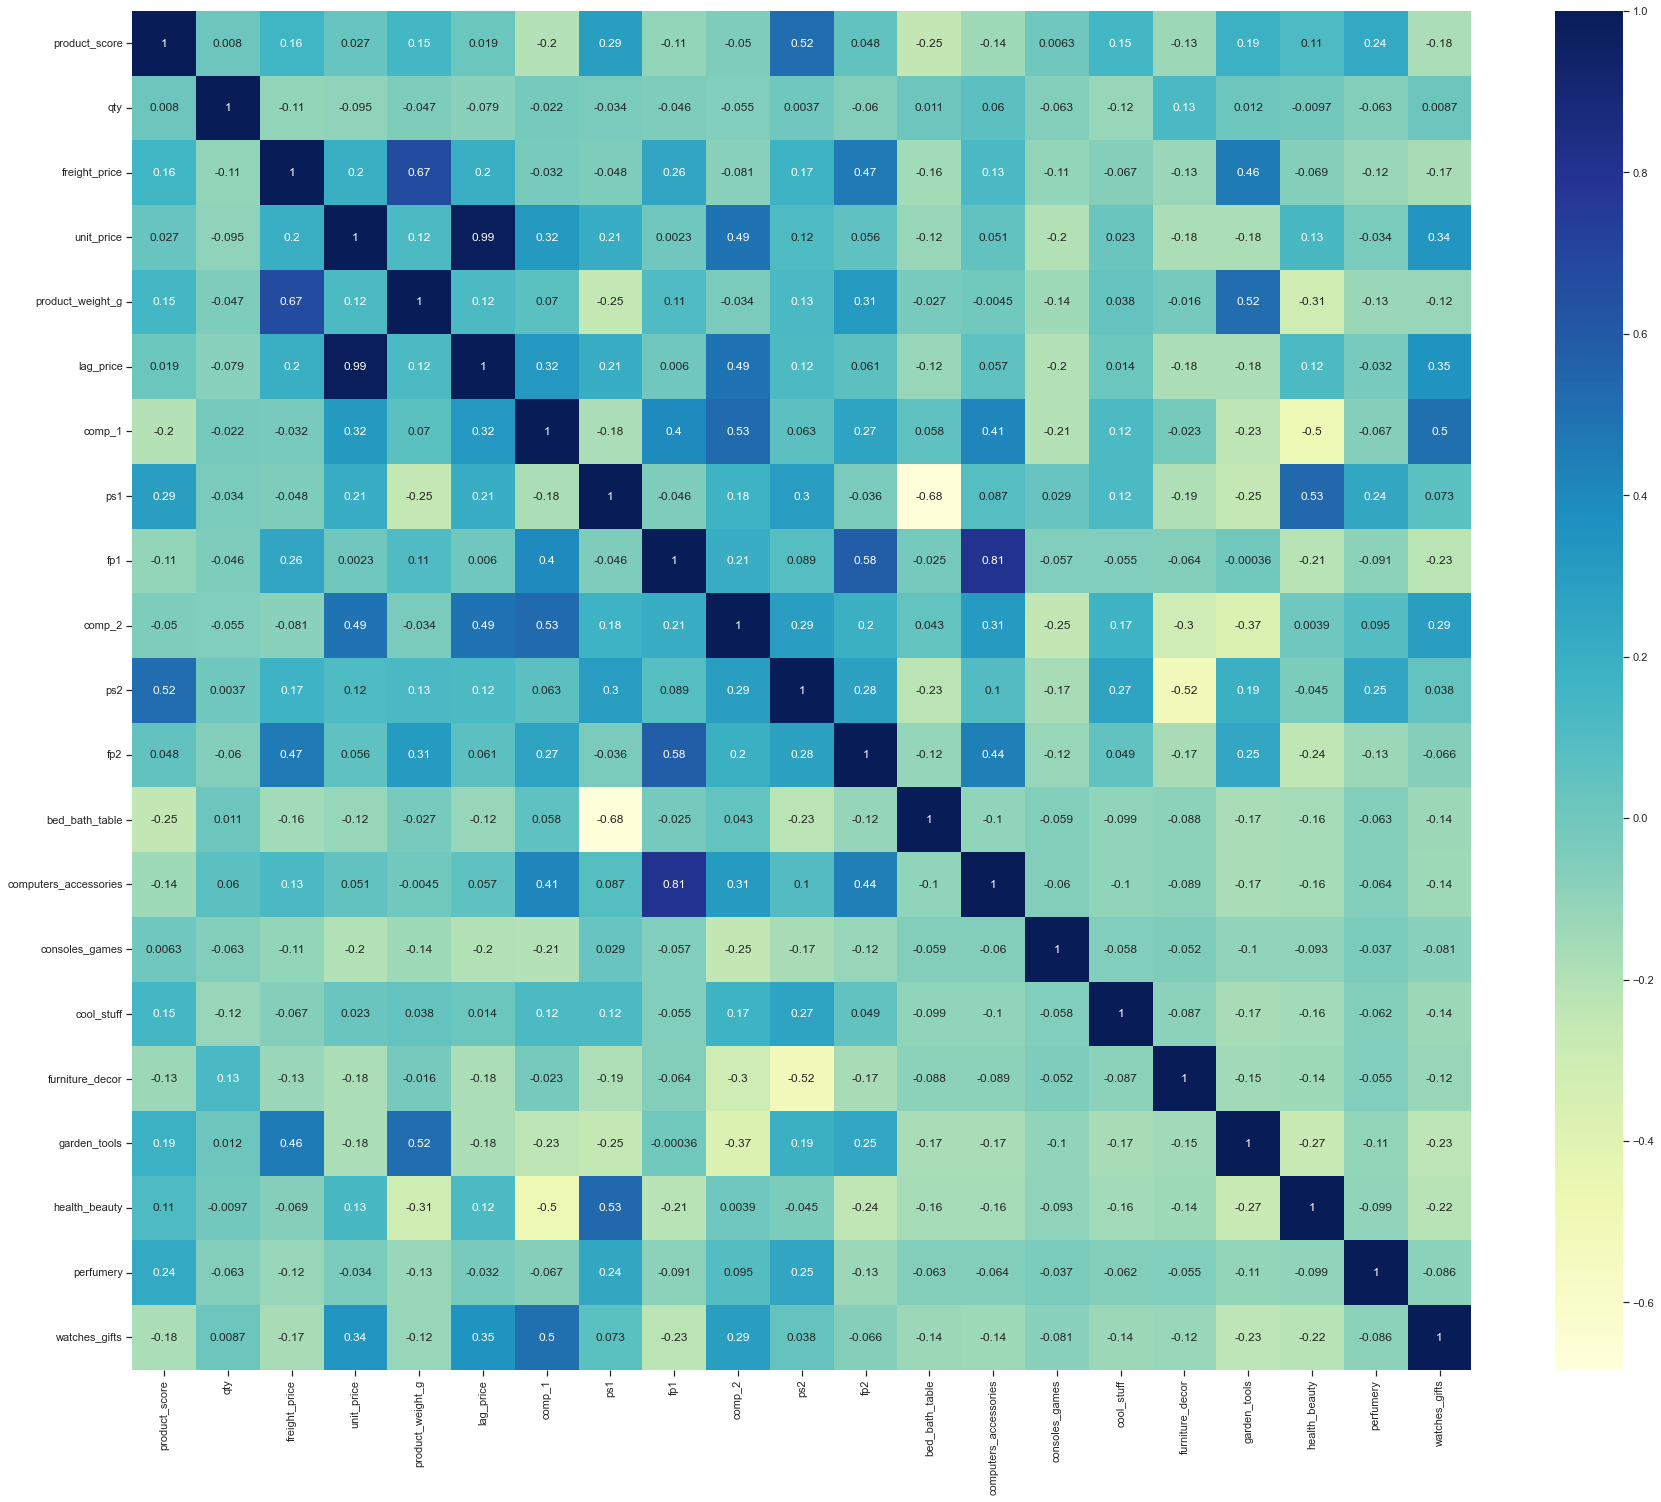

In [46]:
#Correlation using heatmap
plt.figure(figsize = (30, 25))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [47]:
#Dividing data into X and y variables
y_train = df_train.pop('unit_price')
X_train = df_train

In [ ]:
y_train.head(10)

In [ ]:
X_train.columns

In [ ]:
y_test = df_test.pop('unit_price')
X_test = df_test

In [ ]:
y_test.head(10)

In [ ]:
X_test.head()

# Model Building

In [ ]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def get_model():
  model = Sequential([
    Dense(256, activation='relu', input_shape=[len(X_train.keys())]),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss=rmse,
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

get_model().summary()

In [ ]:
callbacks = [EarlyStopping(monitor = "val_loss", patience = 20, verbose = 1)]

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 2000,
    callbacks = [callbacks]
    
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

### Plot Training and Validation Loss

In [ ]:
def plot_loss(history):
    h = history.history
    x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(range(x_lim), h['val_loss'], label = 'Validation Loss')
    plt.plot(range(x_lim), h['loss'], label = 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

plot_loss(history)

## Predict

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(predictions)

In [ ]:
example_batch = X_train[:5]
example_batch

In [ ]:
example_batch = X_test[123:124]
example_batch

example_test = y_test[123:124]
example_test

In [ ]:
example_result = model.predict(example_batch)
print(example_result)

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

## Export Model

In [ ]:
model_json = model.to_json()
with open("model_repfit_v1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("model_repfit_v1.h5")
model.save_weights("model_repfit_weight_v1.h5")